In [1]:
!pip3 install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/evfro/polara.git (to revision develop) to /tmp/pip-install-fswnmgch/polara_e9f7a3ee1aee4bef85936d915026c9aa
  Running command git clone --filter=blob:none --quiet https://github.com/evfro/polara.git /tmp/pip-install-fswnmgch/polara_e9f7a3ee1aee4bef85936d915026c9aa
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/evfro/polara.git to commit 8e48cfd88e616ca53f8bbda1702a3e2c8abaf38e
  Preparing metadata (setup.py) ... done
  Created wheel for polara: filename=polara-0.7.2.dev0-py3-none-any.whl size=89455 sha256=8b20b1b694ffcadfe37c708e9de299255a0563a323dd0f981bda6c033670c004
  Stored in directory: /tmp/pip-ephem-wheel-cache-grqokw6s/wheels/d2/cf/bf/e1a3e49c4a733261d717fa4732eadf0303dabcc48ba694ad7a
Successfull

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.parametrizations import orthogonal
from torch.nn import functional as F
from IPython.display import clear_output

from tqdm.notebook import tqdm

from dataprep import transform_indices, full_preproccessing
from utils import *

In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
def set_random_seed(seed):
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    
set_random_seed(42)

In [4]:
# answer = binary matrix (no ratings)
class MVDataset(Dataset):
    def __init__(self, data, data_description, augment=False):
        useridx = data[data_description['users']].values
        itemidx = data[data_description['items']].values
        feedbackidx = data[data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)
        
        self.tensor = torch.sparse_coo_tensor(np.array([useridx, itemidx, feedbackidx-1]), torch.tensor(values),
                                            size=torch.Size((data_description["n_users"], data_description["n_items"], data_description['n_ratings'])))
        self.matrix = torch.sparse_coo_tensor(np.array([useridx, itemidx]), torch.tensor(values),
                                      size=torch.Size((data_description["n_users"], data_description["n_items"])), dtype=torch.float32)
        
        self.augment = augment

    def __len__(self):
        return self.tensor.shape[0]

    def __getitem__(self, idx):
        if self.augment:
            num_noise = np.random.randint(0, int(0.1*self.matrix.shape[1]))
            idxs = torch.randint(0, self.matrix.shape[1], size=(num_noise,))
            noised_input = self.tensor[idx].detach().clone().to_dense()
            noised_input[idxs] = torch.distributions.bernoulli.Bernoulli(0.5).sample(sample_shape=(num_noise,))
            
            useridx = np.zeros_like(noised_input)
            itemidx = np.arange(self.matrix.shape[1])
            noised_input = torch.sparse_coo_tensor(np.array([itemidx,]), noised_input,
                                                   size=torch.Size((data_description["n_items"],)), dtype=torch.float32)
            return noised_input, self.matrix[idx]
        else:
            return self.tensor[idx], self.matrix[idx]

## Preprocess data

In [5]:
data = pd.read_csv('Amazon_Video_Games.csv')
data.rename(columns = {'reviewerID' : 'userid', 'asin' : 'movieid', "overall" : "rating", "unixReviewTime" : "timestamp"}, inplace = True)

In [6]:
training, testset_valid, holdout_valid, testset, holdout, data_description, data_index = full_preproccessing(data)

There are 24303 users
Filtered 17693 invalid observations.


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda', index=0)

## Model: triangular matrix

In [7]:
def triu_init(m):
    if isinstance(m, nn.Linear):
        with torch.no_grad():
            m.weight.copy_(torch.tril(m.weight))
            
def get_zero_grad_hook(mask):
    def hook(grad):
        return grad * mask
    return hook

In [8]:
class triangularAE(nn.Module):
    def __init__(self, n_items, n_ratings, hid1, hid2):
        super(triangularAE, self).__init__()
        self.V = nn.Linear(n_items, hid1, bias=False)
        torch.nn.init.xavier_uniform_(self.V.weight)
        self.W = nn.Linear(n_ratings, hid2, bias=False)
        torch.nn.init.xavier_uniform_(self.W.weight)
        self.L = nn.Linear(n_ratings, n_ratings, bias=False)
        torch.nn.init.xavier_uniform_(self.L.weight)
        triu_init(self.L)
#         self.norm = nn.LayerNorm(n_ratings)
        self.vec = nn.Linear(n_ratings, 1)
        torch.nn.init.xavier_uniform_(self.vec.weight)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # encode
        x = self.L(x)
        x = self.relu(x)
        x = self.W(x)
        x = self.relu(x)
        xT = torch.transpose(x, -1, -2)
        yT = self.V(xT)
        y = torch.transpose(yT, -1, -2)
        y = self.relu(y)
        # decode
        output = F.linear(y, self.W.weight.T)
        output = self.relu(output)
        outputT = torch.transpose(output, -1, -2)
        outputT = torch.linalg.solve(self.L.weight, outputT)
        outputT = self.relu(outputT)
        outputT = F.linear(outputT, self.V.weight.T)
        output = torch.transpose(outputT, -1, -2)
        
#         output = self.relu(output)
        # vec
        output = self.vec(output).squeeze(-1)
        return output

In [20]:
def triangular_model(h, data_description, device):
    h1, h2 = h
    ae = triangularAE(data_description['n_items'], data_description['n_ratings'], h1, h2).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    mask = torch.tril(torch.ones_like(ae.L.weight))
    ae.L.weight.register_hook(get_zero_grad_hook(mask))
    
    return ae, criterion, optimizer, scheduler

### Tuning

In [17]:
grid1 = 2**np.arange(4, 11)
grid2 = np.arange(3, 6)
grid = np.meshgrid(grid2, grid1)
grid = list(zip(grid[1].flatten(), grid[0].flatten()))

In [ ]:
sizes = 2**np.arange(4,10)
for batch_size in sizes:
    print('Batch size:', batch_size)
    tuning_pipeline(training, testset_valid, holdout_valid, data_description, triangular_model, device, grid, batch_size=batch_size, tensor_model=True)

## Model: triangular banded matrix

In [24]:
class bandedLinear(nn.Module):
    def __init__(self, num_features, bias: bool = True, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        self.device = device
        super().__init__()
        self.num_features = num_features
        self.weight = nn.Parameter(torch.empty((num_features,1), **factory_kwargs))
        if bias:
            self.bias = nn.Parameter(torch.empty(num_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=np.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / np.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        M = torch.zeros((self.num_features, self.num_features), device=self.weight.device)
        for i in range(self.num_features):
            d = torch.ones(self.num_features-i, device=self.weight.device) * self.weight[i]
            M = M + torch.diag(d, diagonal=-i)
        return F.linear(input, M, self.bias)

    def extra_repr(self):
        return 'num_features={}, bias={}'.format(
            self.num_features, self.bias is not None
        )

In [39]:
class triangularbandedAE(nn.Module):
    def __init__(self, n_items, n_ratings, hid1, hid2):
        super(AE, self).__init__()
        self.V = nn.Linear(n_items, hid1)
        torch.nn.init.xavier_uniform_(self.V.weight)
        self.W = nn.Linear(n_ratings, hid2)
        torch.nn.init.xavier_uniform_(self.W.weight)
        self.L = bandedLinear(n_ratings, bias=False)
        torch.nn.init.xavier_uniform_(self.L.weight)
#         self.norm = nn.LayerNorm(n_ratings)
        self.vec = nn.Linear(n_ratings, 1)
        torch.nn.init.xavier_uniform_(self.vec.weight)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        M = torch.zeros((self.L.weight.shape[0], self.L.weight.shape[0]), device=self.L.weight.device)
        for i in range(self.L.weight.shape[0]):
            d = torch.ones(self.L.weight.shape[0]-i, device=self.L.weight.device) * self.L.weight[i]
            M = M + torch.diag(d, diagonal=-i)
        M.require_grad = True
        
        # encode
        x = torch.matmul(x, M.T)
        x = self.relu(x)
        x = self.W(x)
        x = self.relu(x)
        xT = torch.transpose(x, -1, -2)
        yT = self.V(xT)
        y = torch.transpose(yT, -1, -2)
        y = self.relu(y)
        # decode
        output = F.linear(y, self.W.weight.T)
        output = self.relu(output)
        outputT = torch.transpose(output, -1, -2)
        outputT = torch.linalg.solve(self.L.weight, outputT)
        outputT = self.relu(outputT)
        outputT = F.linear(outputT, self.V.weight.T)
        output = torch.transpose(outputT, -1, -2) 
        # output = self.relu(output)
        # vec
        output = self.vec(output).squeeze(-1)
        return output

In [ ]:
def triangular_banded_model(h, data_description, device):
    h1, h2 = h
    ae = triangularbandedAE(data_description['n_items'], data_description['n_ratings'], h1, h2).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    return ae, criterion, optimizer, scheduler

### Tuning

In [ ]:
grid1 = 2**np.arange(4, 11)
grid2 = np.arange(3, 6)
grid = np.meshgrid(grid2, grid1)
grid = list(zip(grid[1].flatten(), grid[0].flatten()))

In [ ]:
sizes = 2**np.arange(4,10)
for batch_size in sizes:
    print('Batch size:', batch_size)
    tuning_pipeline(training, testset_valid, holdout_valid, data_description, triangular_banded_model, device, grid, batch_size=batch_size, tensor_model=True)

## Model: square root matrix

In [ ]:
class squarerootAE(nn.Module):
    def __init__(self, n_items, n_ratings, hid1, hid2):
        super(AE, self).__init__()
        self.V = nn.Linear(n_items, hid1)
        torch.nn.init.xavier_uniform_(self.V.weight)
        self.W = nn.Linear(n_ratings, hid2)
        torch.nn.init.xavier_uniform_(self.W.weight)
        self.L = nn.Linear(n_ratings, n_ratings, bias=False)
        torch.nn.init.xavier_uniform_(self.L.weight)
#         self.norm = nn.LayerNorm(n_ratings)
        self.vec = nn.Linear(n_ratings, 1)
        torch.nn.init.xavier_uniform_(self.vec.weight)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # encode
        x = self.L(x)
#         x = self.norm(x)
        x = self.relu(x)
        x = self.W(x)
        x = self.relu(x)
        xT = torch.transpose(x, -1, -2)
        yT = self.V(xT)
        y = torch.transpose(yT, -1, -2)
        y = self.relu(y)
        # decode
        output = torch.matmul(y, self.W.weight) + self.W.bias
        output = self.relu(output)
        outputT = torch.transpose(output, -1, -2)
        outputT = torch.linalg.solve(self.L.weight, outputT)
        outputT = self.relu(outputT)
        outputT = torch.matmul(outputT, self.V.weight.T) + self.V.bias
        output = torch.transpose(outputT, -1, -2)
        # vec
        output = self.vec(output).squeeze(-1)
        return output

In [ ]:
def square_root_model(h, data_description, device):
    h1, h2 = h
    ae = squarerootAE(data_description['n_items'], data_description['n_ratings'], h1, h2).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    return ae, criterion, optimizer, scheduler

### Tuning

In [ ]:
grid1 = 2**np.arange(4, 11)
grid2 = np.arange(3, 6)
grid = np.meshgrid(grid2, grid1)
grid = list(zip(grid[1].flatten(), grid[0].flatten()))

In [ ]:
sizes = 2**np.arange(4,10)
for batch_size in sizes:
    print('Batch size:', batch_size)
    tuning_pipeline(training, testset_valid, holdout_valid, data_description, square_root_model, device, grid, batch_size=batch_size, tensor_model=True)

## Model: triangular layers are different

In [9]:
def triu_init(m):
    if isinstance(m, nn.Linear):
        with torch.no_grad():
            m.weight.copy_(torch.tril(m.weight))
            
def get_zero_grad_hook(mask):
    def hook(grad):
        return grad * mask
    return hook

In [10]:
class twotriangularAE(nn.Module):
    def __init__(self, n_items, n_ratings, hid1, hid2):
        super(twotriangularAE, self).__init__()
        self.V = nn.Linear(n_items, hid1, bias=False)
        torch.nn.init.xavier_uniform_(self.V.weight)
        self.W = nn.Linear(n_ratings, hid2, bias=False)
        torch.nn.init.xavier_uniform_(self.W.weight)
        self.L = nn.Linear(n_ratings, n_ratings, bias=False)
        torch.nn.init.xavier_uniform_(self.L.weight)
        triu_init(self.L)
        self.LTinv = nn.Linear(n_ratings, n_ratings, bias=False)
        torch.nn.init.xavier_uniform_(self.LTinv.weight)
        triu_init(self.LTinv)
        
#         self.norm = nn.LayerNorm(n_ratings)
        self.vec = nn.Linear(n_ratings, 1)
        torch.nn.init.xavier_uniform_(self.vec.weight)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # encode
        x = self.L(x)
        x = self.relu(x)
        x = self.W(x)
        x = self.relu(x)
        xT = torch.transpose(x, -1, -2)
        yT = self.V(xT)
        y = torch.transpose(yT, -1, -2)
        y = self.relu(y)
        # decode
        output = F.linear(y, self.W.weight.T)
        output = self.relu(output)
        output = self.LTinv(output)
        output = self.relu(output)
        outputT = torch.transpose(output, -1, -2)
        outputT = F.linear(outputT, self.V.weight.T)
        output = torch.transpose(outputT, -1, -2)
        
#         output = self.relu(output)
        # vec
        output = self.vec(output).squeeze(-1)
        return output

In [11]:
def twotriangular_model(h, data_description, device):
    h1, h2 = h
    ae = twotriangularAE(data_description['n_items'], data_description['n_ratings'], h1, h2).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    mask = torch.tril(torch.ones_like(ae.L.weight))
    ae.L.weight.register_hook(get_zero_grad_hook(mask))
    
    mask = torch.tril(torch.ones_like(ae.LTinv.weight))
    ae.LTinv.weight.register_hook(get_zero_grad_hook(mask))
    
    return ae, criterion, optimizer, scheduler

### Tuning

In [12]:
grid1 = 2**np.arange(4, 11)
grid2 = np.arange(3, 6)
grid = np.meshgrid(grid2, grid1)
grid = list(zip(grid[1].flatten(), grid[0].flatten()))

Batch size: 16


  0%|          | 0/21 [00:00<?, ?it/s]

Hidden sizes: (16, 3)


C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))


Current epoch 86
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.003004,0.000814,0.002827,0.001344,0.003004,0.0,0.000814,0.0,0.001344,0.0,0.0115


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.004506,0.000989,0.004846,0.001805,0.004506,0.0,0.000989,0.0,0.001805,0.0,0.014096


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.010013,0.001292,0.007369,0.003096,0.009762,0.00025,0.00128,0.000013,0.003039,0.000057,0.008544


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.003004,0.000814,0.002827,0.001344,0.003004,0.0,0.000814,0.0,0.001344,0.0,0.016848


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.004506,0.000989,0.004846,0.001805,0.004506,0.0,0.000989,0.0,0.001805,0.0,0.020651


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.010013,0.001292,0.007369,0.003096,0.009512,0.000501,0.001267,0.000025,0.002982,0.000114,0.012945


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.003004,0.000814,0.002827,0.001344,0.002753,0.00025,0.000751,0.000063,0.001236,0.000108,0.01484


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.004506,0.000989,0.004846,0.001805,0.004255,0.00025,0.000926,0.000063,0.001697,0.000108,0.02296


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.010013,0.001292,0.007369,0.003096,0.009262,0.000751,0.001205,0.000088,0.002874,0.000222,0.02933


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.00025,0.00025,0.003028,0.00025,0.00025,0.0,0.00025,0.0,0.00025,0.0,0.012759


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.000751,0.000317,0.004946,0.000412,0.000751,0.0,0.000317,0.0,0.000412,0.0,0.022104


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.006758,0.000689,0.00747,0.001873,0.005006,0.001752,0.000573,0.000115,0.001438,0.000435,0.022745


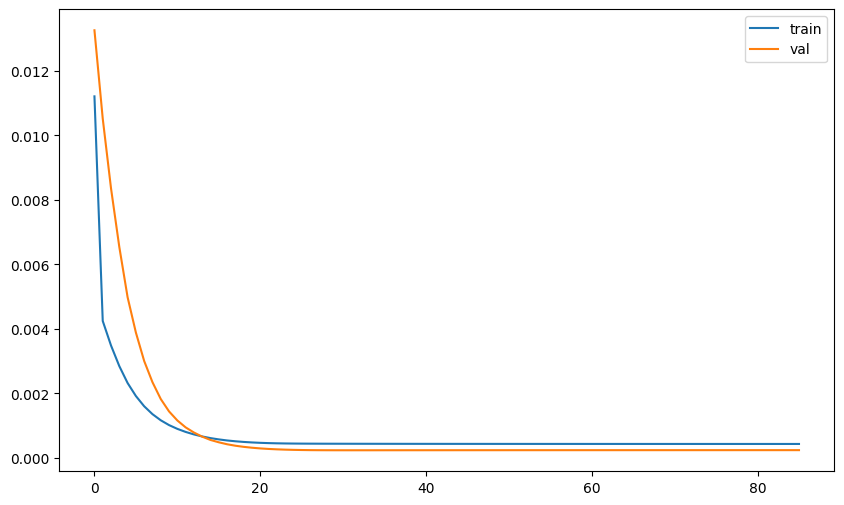

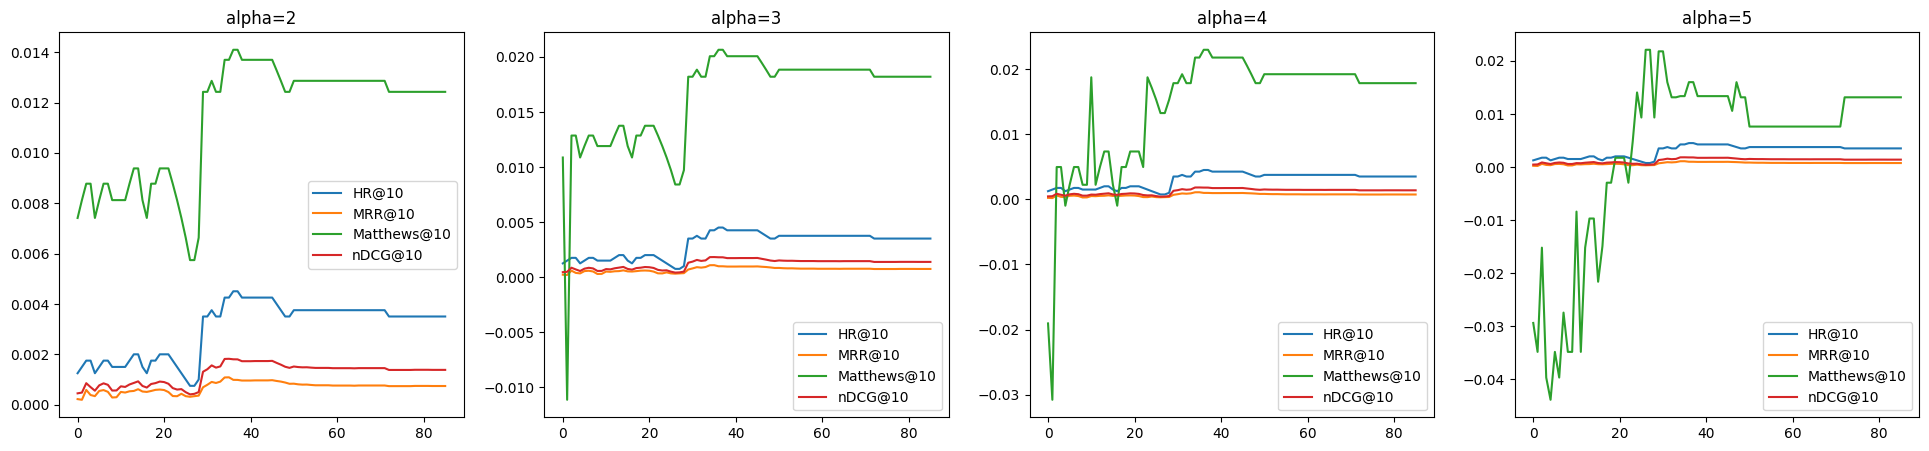

Test loss: 0.0002374546165810898
Train loss: 0.00043670634311708333


Hidden sizes: (16, 4)
Current epoch 131
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.00025,0.000083,0.003129,0.000125,0.00025,0.0,0.000083,0.0,0.000125,0.0,0.003315


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.004255,0.000568,0.00636,0.001371,0.004255,0.0,0.000568,0.0,0.001371,0.0,0.013697


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.010263,0.000946,0.009489,0.002844,0.010013,0.00025,0.000928,0.000018,0.00278,0.000064,0.008961


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.00025,0.000083,0.003129,0.000125,0.00025,0.0,0.000083,0.0,0.000125,0.0,0.004857


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.004255,0.000568,0.00636,0.001371,0.004255,0.0,0.000568,0.0,0.001371,0.0,0.020066


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.010263,0.000946,0.009489,0.002844,0.009762,0.000501,0.000912,0.000035,0.002717,0.000127,0.01355


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.00025,0.000083,0.003129,0.000125,0.00025,0.0,0.000083,0.0,0.000125,0.0,0.007645


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.004255,0.000568,0.00636,0.001371,0.004005,0.00025,0.000537,0.000031,0.001292,0.000079,0.021765


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.010263,0.000946,0.009489,0.002844,0.009512,0.000751,0.00088,0.000066,0.002638,0.000206,0.030174


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.000751,0.000196,0.003028,0.00033,0.000751,0.0,0.000196,0.0,0.00033,0.0,0.022104


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.001502,0.000299,0.005148,0.000575,0.001502,0.0,0.000299,0.0,0.000575,0.0,0.031271


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.003504,0.000434,0.007369,0.001076,0.002503,0.001001,0.000363,0.00007,0.000822,0.000254,0.013141


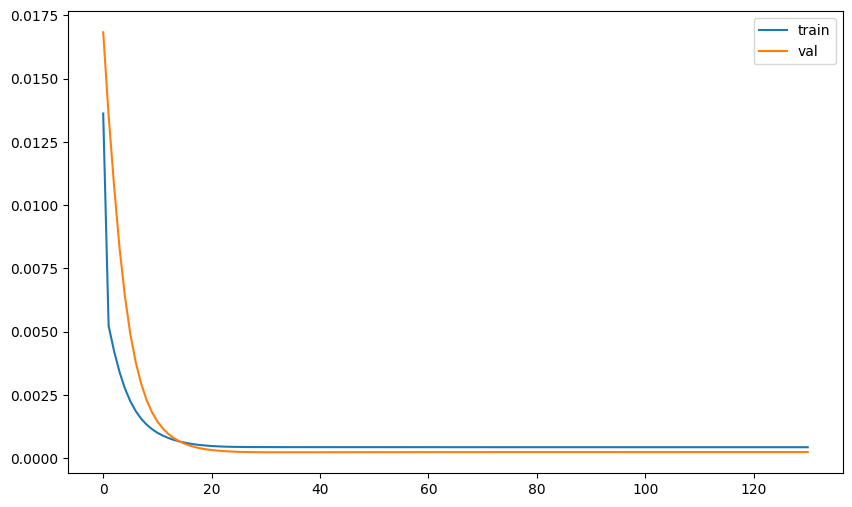

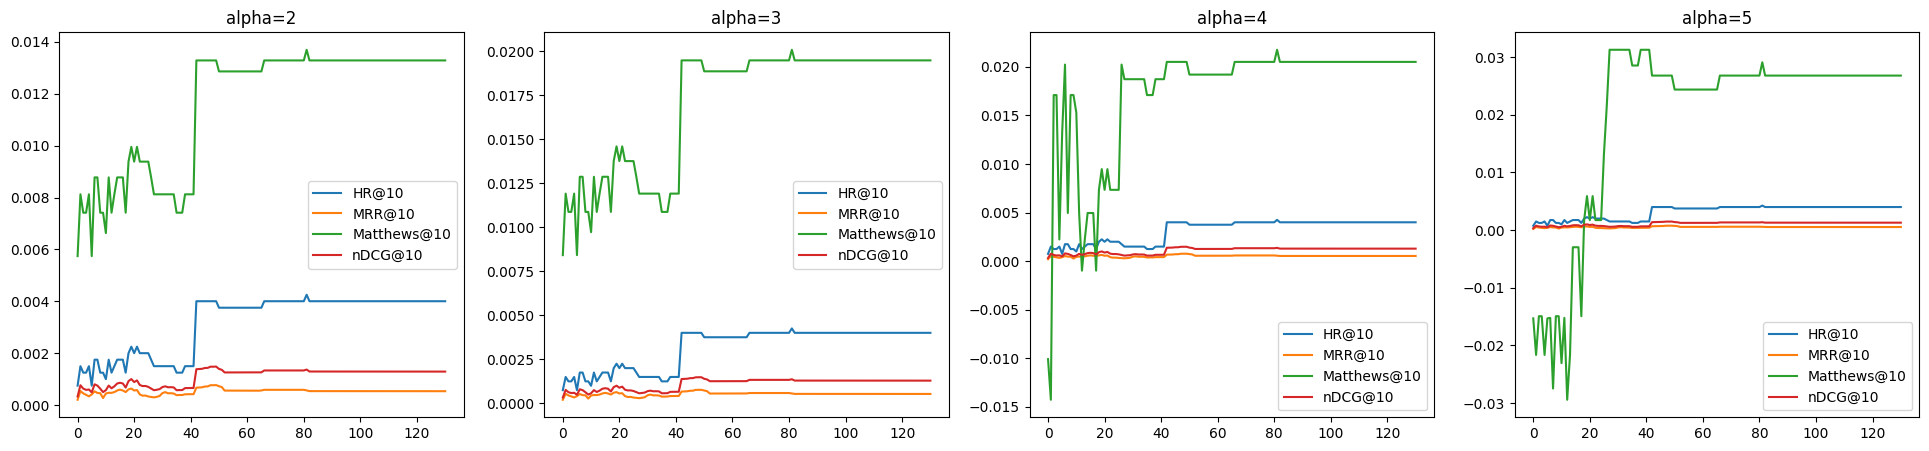

Test loss: 0.0002440234093228355
Train loss: 0.0004365210088636807


Hidden sizes: (16, 5)
Current epoch 92
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.00025,0.00025,0.002928,0.00025,0.00025,0.0,0.00025,0.0,0.00025,0.0,0.003315


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.003504,0.000613,0.004745,0.001231,0.003504,0.0,0.000613,0.0,0.001231,0.0,0.012425


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.006508,0.000814,0.007268,0.001981,0.006508,0.0,0.000814,0.0,0.001981,0.0,0.016958


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.00025,0.00025,0.002928,0.00025,0.00025,0.0,0.00025,0.0,0.00025,0.0,0.004857


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.003504,0.000613,0.004745,0.001231,0.003504,0.0,0.000613,0.0,0.001231,0.0,0.018203


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.006508,0.000814,0.007268,0.001981,0.006508,0.0,0.000814,0.0,0.001981,0.0,0.024844


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.001001,0.000321,0.003028,0.000488,0.001001,0.0,0.000321,0.0,0.000488,0.0,0.015295


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.001752,0.000402,0.005148,0.000711,0.001752,0.0,0.000402,0.0,0.000711,0.0,0.020241


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.003504,0.000514,0.007369,0.001141,0.003254,0.00025,0.000493,0.000021,0.001074,0.000068,0.017836


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.00025,0.00025,0.002827,0.00025,0.00025,0.0,0.00025,0.0,0.00025,0.0,0.012759


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.001502,0.000385,0.004745,0.000622,0.001502,0.0,0.000385,0.0,0.000622,0.0,0.031271


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.006508,0.000768,0.006965,0.001931,0.005006,0.001502,0.000649,0.000118,0.001533,0.000397,0.027036


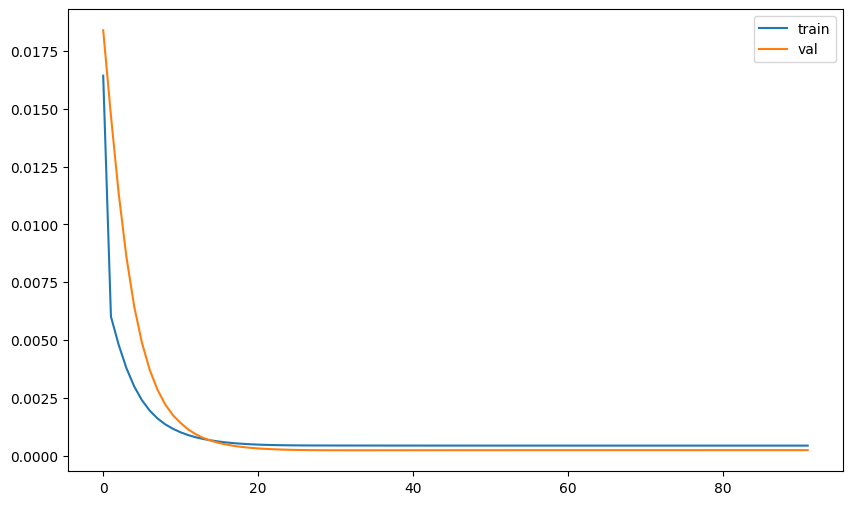

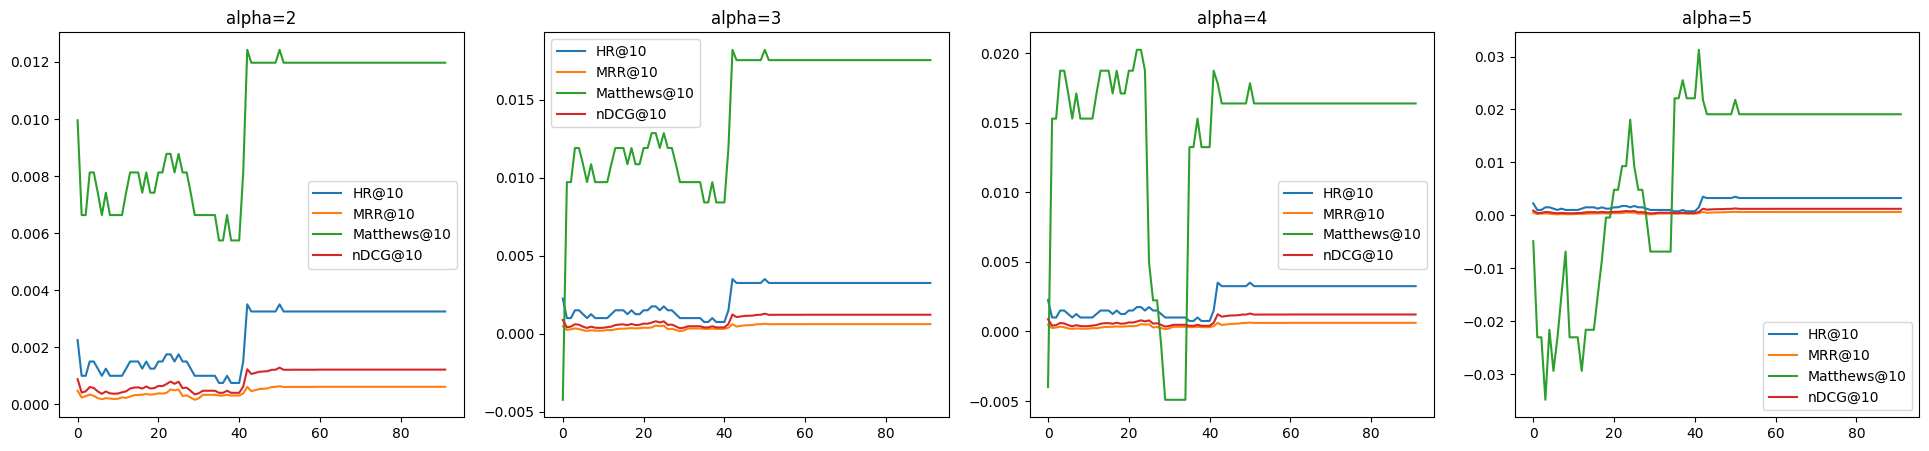

Test loss: 0.00023726663494016975
Train loss: 0.0004382619035694667


Hidden sizes: (32, 3)
Current epoch 121
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.006508,0.003342,0.05532,0.004116,0.006258,0.00025,0.003292,0.00005,0.004019,0.000097,0.001448


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.012766,0.003989,0.078437,0.005969,0.012516,0.00025,0.003939,0.00005,0.005872,0.000097,0.012716


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.017272,0.004249,0.113164,0.007045,0.016771,0.000501,0.004185,0.000064,0.006889,0.000156,0.008631


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.004506,0.002653,0.044619,0.003115,0.004506,0.0,0.002653,0.0,0.003115,0.0,0.020651


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.009262,0.00319,0.070563,0.00457,0.009011,0.00025,0.003148,0.000042,0.004481,0.000089,0.020363


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.015519,0.003545,0.100848,0.006056,0.015019,0.000501,0.003489,0.000056,0.005908,0.000148,0.024102


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.007509,0.003605,0.051181,0.004558,0.006508,0.001001,0.003317,0.000288,0.004098,0.000459,0.012414


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.011264,0.003957,0.075308,0.00564,0.010263,0.001001,0.003694,0.000263,0.005205,0.000435,0.027344


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.016521,0.004252,0.107914,0.006885,0.014768,0.001752,0.003945,0.000307,0.00627,0.000615,0.027522


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.006508,0.003354,0.054916,0.004127,0.004005,0.002503,0.002507,0.000847,0.002875,0.001252,0.001553


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.012516,0.003996,0.079144,0.005926,0.009011,0.003504,0.003135,0.000861,0.004454,0.001472,0.026264


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.017021,0.004262,0.112255,0.007012,0.012015,0.005006,0.003326,0.000936,0.005193,0.001818,0.026897


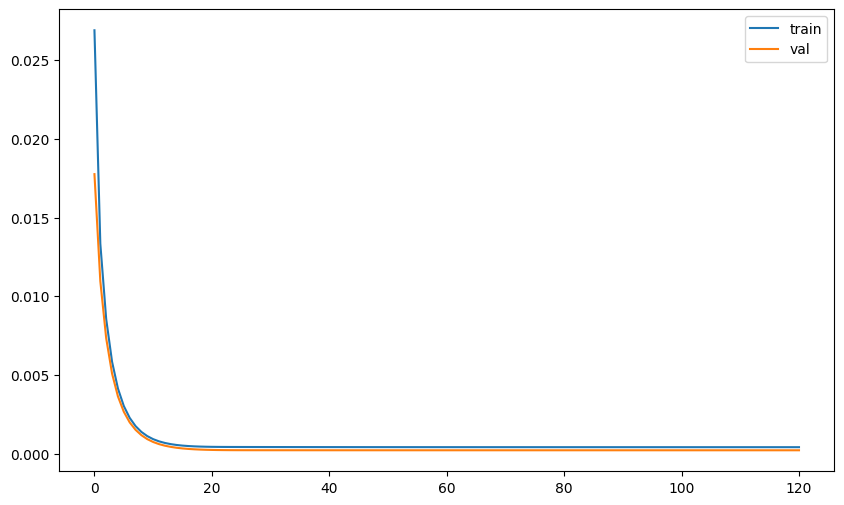

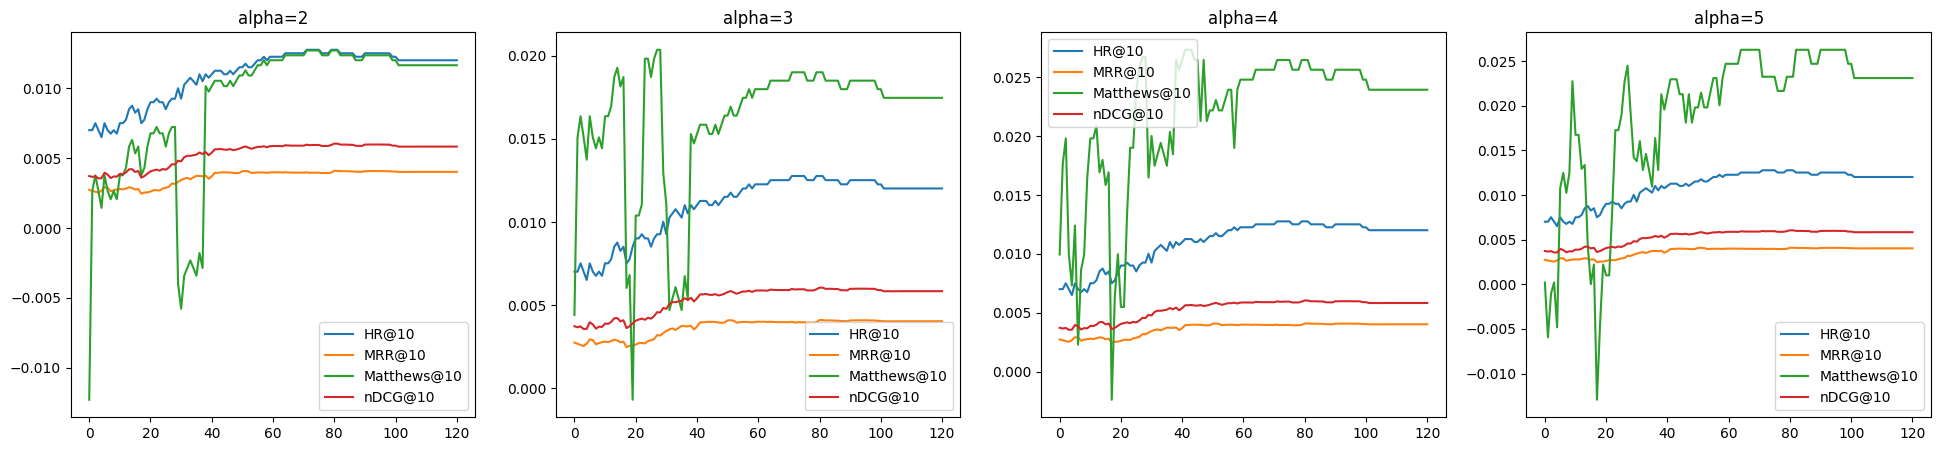

Test loss: 0.000215554449823685
Train loss: 0.00041281971010219203


Hidden sizes: (32, 4)
Current epoch 123
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002253,0.000935,0.010196,0.001259,0.002253,0.0,0.000935,0.0,0.001259,0.0,0.009956


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.004756,0.001237,0.014436,0.002036,0.004756,0.0,0.001237,0.0,0.002036,0.0,0.014484


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.00801,0.001457,0.022613,0.002852,0.00801,0.0,0.001457,0.0,0.002852,0.0,0.018827


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002253,0.000935,0.010196,0.001259,0.002253,0.0,0.000935,0.0,0.001259,0.0,0.014586


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.004756,0.001237,0.014436,0.002036,0.004756,0.0,0.001237,0.0,0.002036,0.0,0.021219


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.00801,0.001457,0.022613,0.002852,0.00776,0.00025,0.001441,0.000016,0.002791,0.000061,0.017572


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002003,0.000976,0.000909,0.001226,0.002003,0.0,0.000976,0.0,0.001226,0.0,0.021641


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.002003,0.000976,0.001413,0.001226,0.002003,0.0,0.000976,0.0,0.001226,0.0,0.021641


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.003504,0.001072,0.002726,0.001595,0.003504,0.0,0.001072,0.0,0.001595,0.0,0.02865


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.001752,0.000663,0.000909,0.000925,0.001752,0.0,0.000663,0.0,0.000925,0.0,0.033781


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.001752,0.000663,0.001716,0.000925,0.001752,0.0,0.000663,0.0,0.000925,0.0,0.033781


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.003504,0.000803,0.002524,0.001391,0.003004,0.000501,0.000761,0.000042,0.001255,0.000136,0.030478


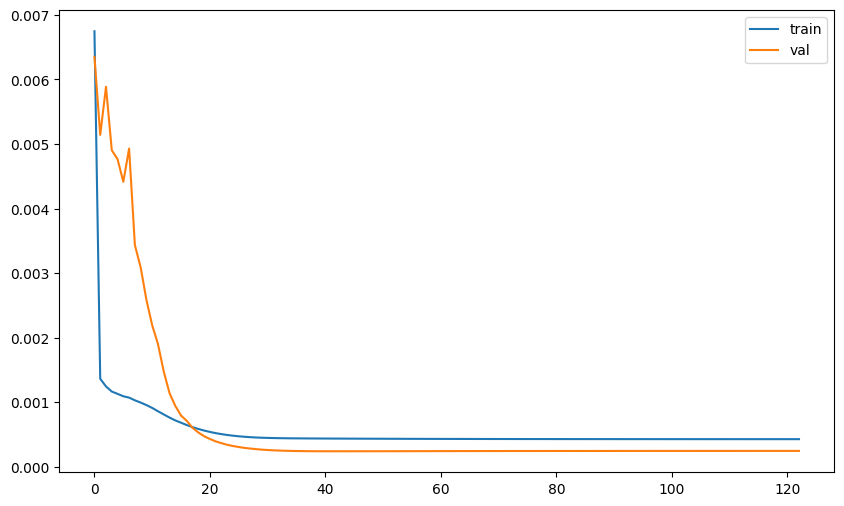

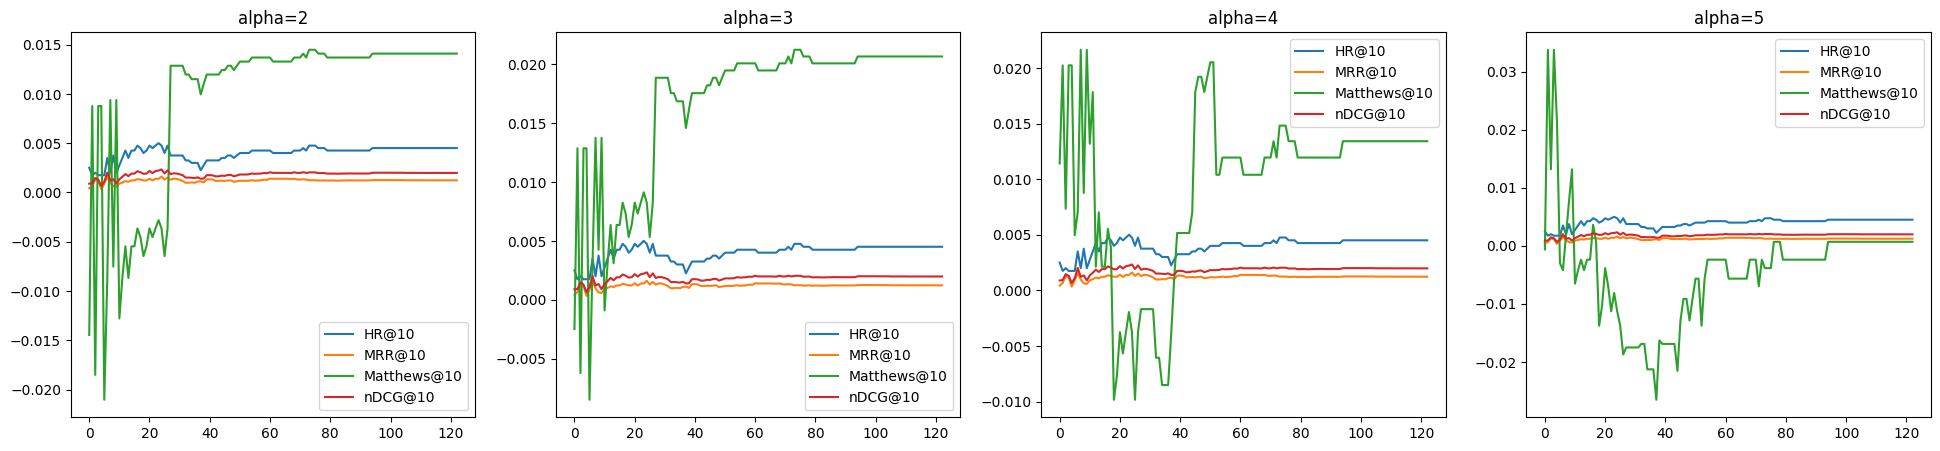

Test loss: 0.00024268463312182575
Train loss: 0.0004283118352945314


Hidden sizes: (32, 5)
Current epoch 75
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002253,0.000997,0.032001,0.001301,0.002253,0.0,0.000997,0.0,0.001301,0.0,0.009956


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.002753,0.000917,0.05956,0.001332,0.002753,0.0,0.000917,0.0,0.001332,0.0,0.011009


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.004506,0.001094,0.100949,0.001808,0.004255,0.00025,0.001078,0.000016,0.001746,0.000061,-0.004526


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002253,0.000997,0.032001,0.001301,0.002253,0.0,0.000997,0.0,0.001301,0.0,0.014586


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.002753,0.000917,0.05956,0.001332,0.002753,0.0,0.000917,0.0,0.001332,0.0,0.016129


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.004506,0.001094,0.100949,0.001808,0.004255,0.00025,0.001078,0.000016,0.001746,0.000061,0.007327


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002003,0.000797,0.045831,0.00109,0.001752,0.00025,0.000747,0.00005,0.000993,0.000097,0.007346


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.002253,0.000682,0.070967,0.001039,0.002003,0.00025,0.000657,0.000025,0.000966,0.000072,0.009478


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.004255,0.000879,0.099939,0.00158,0.003504,0.000751,0.000833,0.000046,0.001398,0.000182,0.002131


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.001252,0.000371,0.018978,0.000585,0.000751,0.000501,0.000196,0.000175,0.00033,0.000255,-0.000435


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.001252,0.000232,0.028871,0.000461,0.000751,0.000501,0.000171,0.000061,0.000305,0.000156,-0.000435


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.003004,0.000411,0.046739,0.000939,0.001752,0.001252,0.000324,0.000087,0.000623,0.000316,-0.002547


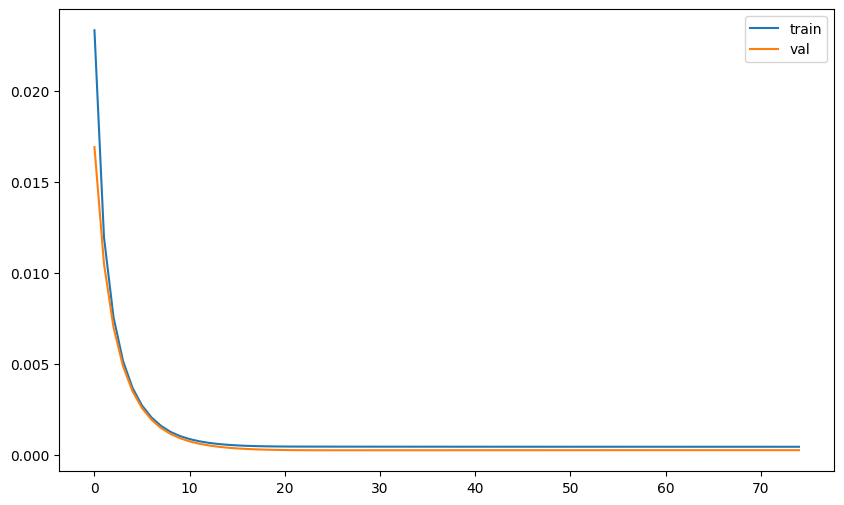

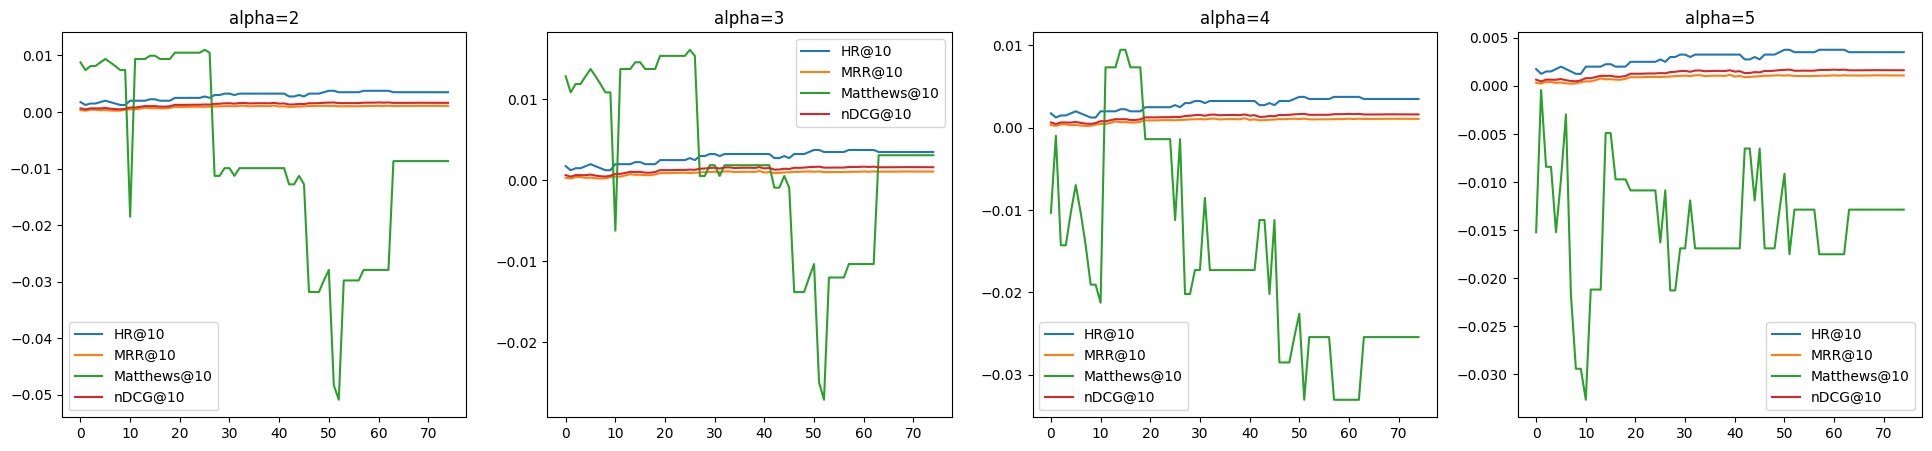

Test loss: 0.00023238932772073895
Train loss: 0.0004324241328832273


Hidden sizes: (64, 3)
Current epoch 76
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002253,0.001227,0.051484,0.001476,0.002253,0.0,0.001227,0.0,0.001476,0.0,0.009956


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.002753,0.001151,0.072582,0.001511,0.002753,0.0,0.001151,0.0,0.001511,0.0,0.011009


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.004005,0.001299,0.095195,0.001868,0.004005,0.0,0.001299,0.0,0.001868,0.0,0.013286


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002253,0.001227,0.051484,0.001476,0.002253,0.0,0.001227,0.0,0.001476,0.0,0.014586


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.002753,0.001151,0.072582,0.001511,0.002753,0.0,0.001151,0.0,0.001511,0.0,0.016129


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.004005,0.001299,0.095195,0.001868,0.003755,0.00025,0.001278,0.000021,0.0018,0.000068,0.005337


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002003,0.00106,0.052796,0.001293,0.001752,0.00025,0.00101,0.00005,0.001196,0.000097,0.007346


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.002753,0.00102,0.08086,0.001412,0.002503,0.00025,0.000994,0.000025,0.00134,0.000072,0.013191


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.004756,0.001199,0.109025,0.001932,0.004255,0.000501,0.001173,0.000026,0.001816,0.000116,0.01482


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.001502,0.000622,0.048153,0.000835,0.000751,0.000751,0.000363,0.000259,0.000455,0.00038,-0.008414


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.002003,0.000535,0.068746,0.000859,0.001252,0.000751,0.000391,0.000144,0.000578,0.000281,0.001741


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.002753,0.000646,0.087826,0.001085,0.002003,0.000751,0.00053,0.000115,0.000838,0.000248,0.01304


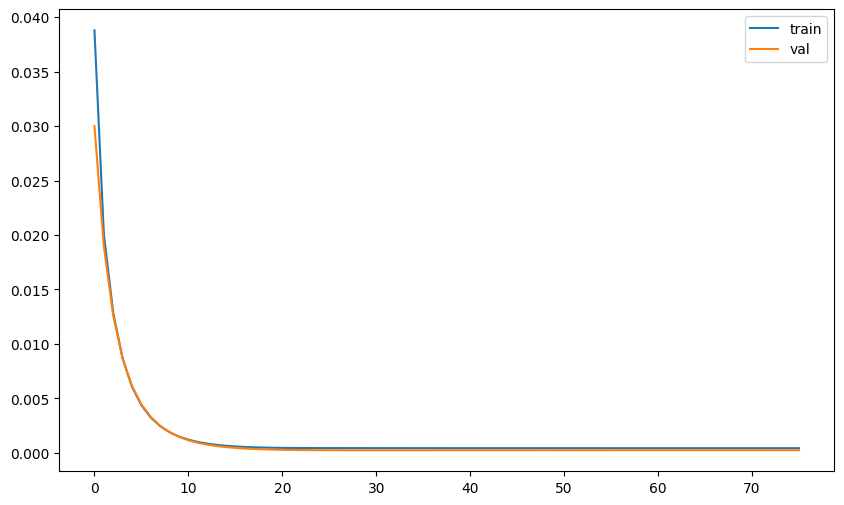

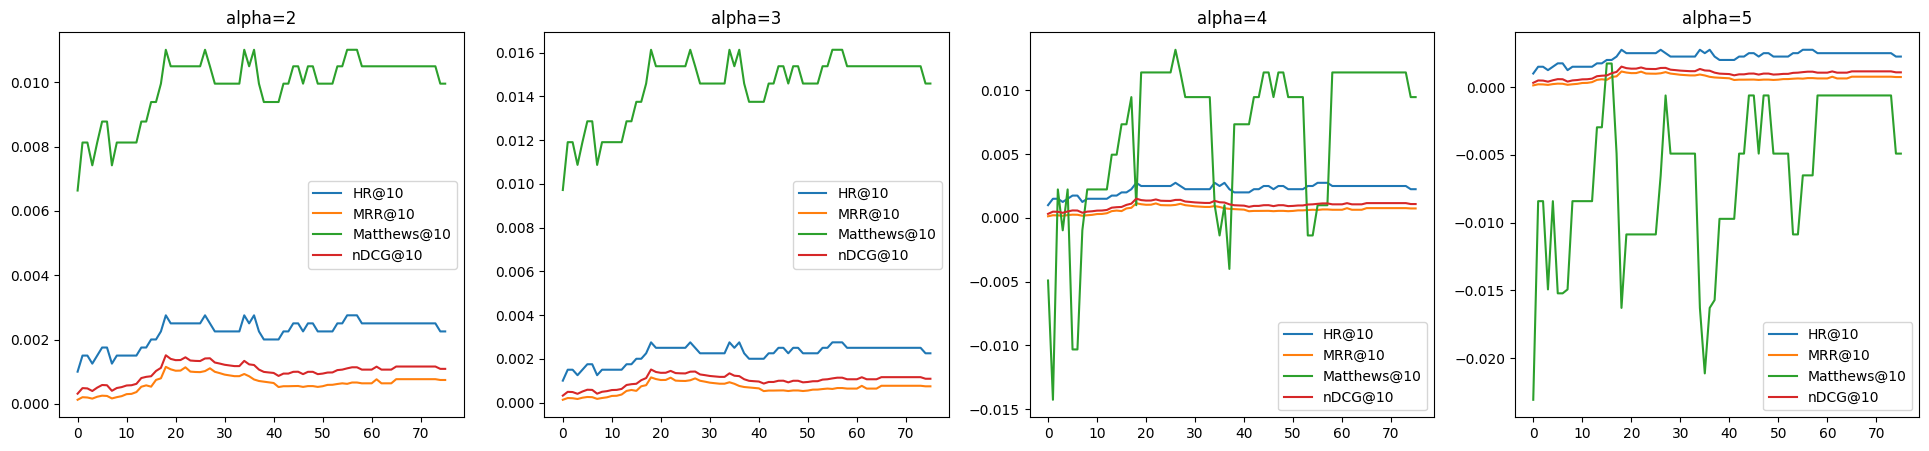

Test loss: 0.0002356084150960669
Train loss: 0.00043311465484759744


Hidden sizes: (64, 4)
Current epoch 93
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.001752,0.000976,0.052493,0.001168,0.001752,0.0,0.000976,0.0,0.001168,0.0,0.008778


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.002503,0.000921,0.086614,0.001271,0.002503,0.0,0.000921,0.0,0.001271,0.0,0.010496


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.004506,0.001112,0.134161,0.001807,0.004255,0.00025,0.001095,0.000017,0.001744,0.000063,-0.004526


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.001252,0.000726,0.051181,0.000852,0.001252,0.0,0.000726,0.0,0.000852,0.0,0.010866


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.002253,0.000717,0.083384,0.001049,0.002253,0.0,0.000717,0.0,0.001049,0.0,0.014586


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.004255,0.000917,0.116293,0.001596,0.003755,0.000501,0.000886,0.000031,0.001473,0.000123,-0.00735


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.001252,0.000726,0.051181,0.000852,0.001001,0.00025,0.000676,0.00005,0.000755,0.000097,-0.000973


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.002253,0.000717,0.083384,0.001049,0.002003,0.00025,0.000692,0.000025,0.000977,0.000072,0.009478


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.004255,0.000917,0.116293,0.001596,0.003004,0.001252,0.00083,0.000088,0.001278,0.000317,-0.017504


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.001502,0.000788,0.048153,0.00096,0.000751,0.000751,0.000363,0.000426,0.000455,0.000505,-0.008414


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.001752,0.000677,0.082172,0.000912,0.001001,0.000751,0.000366,0.000311,0.000506,0.000406,-0.002965


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.004255,0.000907,0.120533,0.001579,0.002003,0.002253,0.000521,0.000386,0.000826,0.000752,-0.018117


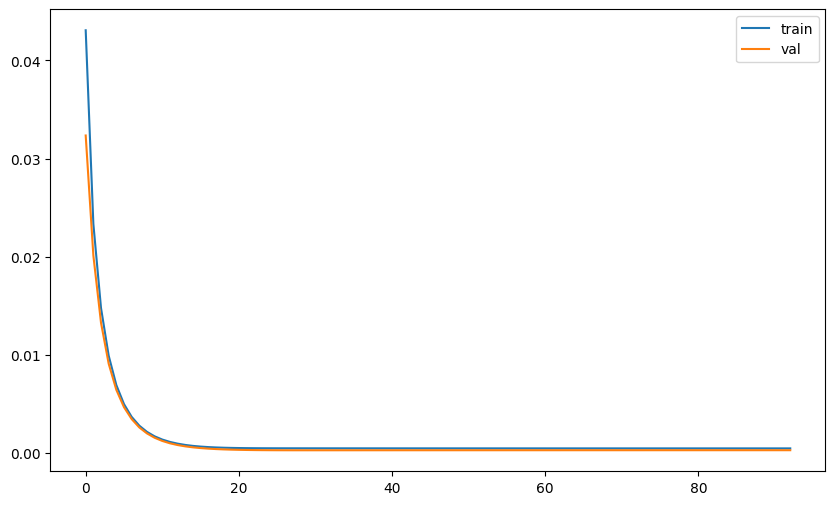

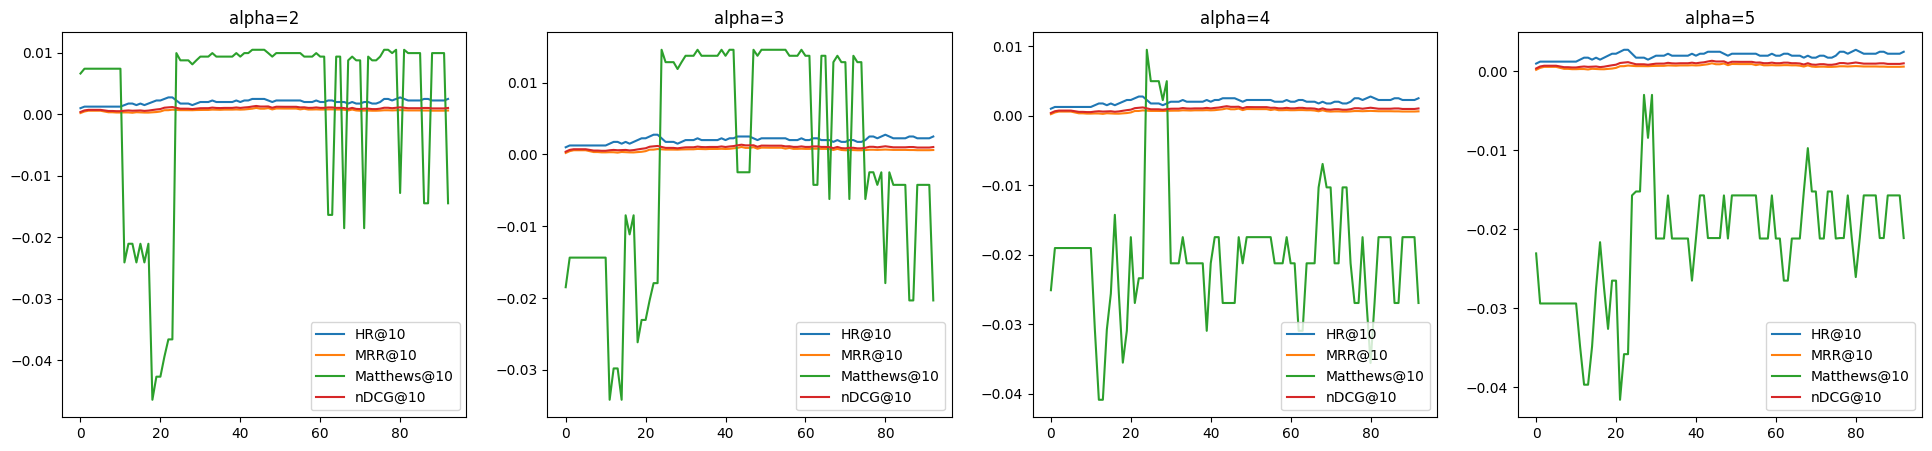

Test loss: 0.0002355780015932396
Train loss: 0.0004295286796118407


Hidden sizes: (64, 5)


In [ ]:
sizes = 2**np.arange(4,10)
for batch_size in sizes:
    print('Batch size:', batch_size)
    tuning_pipeline(training, testset_valid, holdout_valid, data_description, twotriangular_model, device, grid, batch_size=batch_size, tensor_model=True)

## Model: encoder and decoder layers different

In [ ]:
def triu_init(m):
    if isinstance(m, nn.Linear):
        with torch.no_grad():
            m.weight.copy_(torch.tril(m.weight))
            
def get_zero_grad_hook(mask):
    def hook(grad):
        return grad * mask
    return hook

In [ ]:
class vartriangularAE(nn.Module):
    def __init__(self, n_items, n_ratings, hid1, hid2):
        super(twotriangularAE, self).__init__()
        self.V = nn.Linear(n_items, hid1, bias=False)
        torch.nn.init.xavier_uniform_(self.V.weight)
        self.VT = nn.Linear(hid1, n_items, bias=False)
        torch.nn.init.xavier_uniform_(self.VT.weight)
        self.W = nn.Linear(n_ratings, hid2, bias=False)
        torch.nn.init.xavier_uniform_(self.W.weight)
        self.WT = nn.Linear(hid2, n_ratings, bias=False)
        torch.nn.init.xavier_uniform_(self.WT.weight)
        self.L = nn.Linear(n_ratings, n_ratings, bias=False)
        torch.nn.init.xavier_uniform_(self.L.weight)
        triu_init(self.L)
        self.LTinv = nn.Linear(n_ratings, n_ratings, bias=False)
        torch.nn.init.xavier_uniform_(self.LTinv.weight)
        triu_init(self.LTinv)
        
#         self.norm = nn.LayerNorm(n_ratings)
        self.vec = nn.Linear(n_ratings, 1)
        torch.nn.init.xavier_uniform_(self.vec.weight)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # encode
        x = self.L(x)
        x = self.relu(x)
        x = self.W(x)
        x = self.relu(x)
        xT = torch.transpose(x, -1, -2)
        yT = self.V(xT)
        y = torch.transpose(yT, -1, -2)
        y = self.relu(y)
        # decode
        output = self.WT(y)
        output = self.relu(output)
        output = self.LTinv(output)
        outputT = self.relu(outputT)
        outputT = torch.transpose(output, -1, -2)
        outputT = self.VT(outputT)
        output = torch.transpose(outputT, -1, -2)
        
#         output = self.relu(output)
        # vec
        output = self.vec(output).squeeze(-1)
        return output

In [ ]:
def vartriangular_model(h, data_description, device):
    h1, h2 = h
    ae = vartriangularAE(data_description['n_items'], data_description['n_ratings'], h1, h2).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    mask = torch.tril(torch.ones_like(ae.L.weight))
    ae.L.weight.register_hook(get_zero_grad_hook(mask))
    
    mask = torch.tril(torch.ones_like(ae.LTinv.weight))
    ae.LTinv.weight.register_hook(get_zero_grad_hook(mask))
    
    return ae, criterion, optimizer, scheduler

### Tuning

In [17]:
grid1 = 2**np.arange(4, 11)
grid2 = np.arange(3, 6)
grid = np.meshgrid(grid2, grid1)
grid = list(zip(grid[1].flatten(), grid[0].flatten()))

In [ ]:
sizes = 2**np.arange(4,10)
for batch_size in sizes:
    print('Batch size:', batch_size)
    tuning_pipeline(training, testset_valid, holdout_valid, data_description, vartriangular_model, device, grid, batch_size=batch_size, tensor_model=True)

## Model: output -- tensor

In [ ]:
class TensorDataset(Dataset):
    def __init__(self, data, data_description):
        useridx = data[data_description['users']].values
        itemidx = data[data_description['items']].values
        feedbackidx = data[data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)
        
        self.tensor = torch.sparse_coo_tensor(np.array([useridx, itemidx, feedbackidx-1]), torch.tensor(values),
                                            size=torch.Size((data_description["n_users"], data_description["n_items"], data_description['n_ratings'])))

    def __len__(self):
        return self.tensor.shape[0]

    def __getitem__(self, idx):
        return self.tensor[idx], self.tensor[idx]

In [ ]:
train_dataset = MVDataset(training, data_description)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
class AE(nn.Module):
    def __init__(self, n_items, n_ratings, hid1, hid2, hid3):
        super(AE, self).__init__()
        self.V = nn.Linear(n_items, hid1)
        self.W = nn.Linear(hid3, hid2)
        self.L = nn.Linear(n_ratings, hid3)
        triu_init(self.L)
#         self.vec = nn.Linear(n_ratings, 1)
#         self.tanh = nn.Tanh()
        
    def forward(self, x):
        # encode
        x = self.L(x)
        x = self.W(x)
        xT = torch.transpose(x, -1, -2)
        yT = self.V(xT)
        y = torch.transpose(yT, -1, -2)
        # decode
        output = torch.matmul(y, self.W.weight)
        output = torch.matmul(output, self.L.weight)
        output = torch.transpose(torch.matmul(torch.transpose(output, -1, -2), self.V.weight), -1, -2)
        # vec
#         output = self.tanh(output)
#         output = self.vec(output).squeeze(-1)
        return output

ae = AE(data_description['n_items'], data_description['n_ratings'], 100, 50, 20).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(ae.parameters())

In [ ]:
mask = torch.triu(torch.ones_like(ae.L.weight))
# Register with hook
ae.L.weight.register_hook(get_zero_grad_hook(mask))

In [ ]:
# Training the AE
n_epochs = 100
history = []

for epoch in range(1, n_epochs + 1):   
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        user_tensor, true_user_tensor = batch
        
        input_tensor = user_tensor.to_dense().to(device)
        target = true_user_tensor.to_dense().to(device)
        
        output = ae(input_tensor)
        target.require_grad = False # we don't use it in training

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
        
    history.append(train_loss / len(train_dataloader))
        
    print('epoch: '+str(epoch)+' loss: '+str(train_loss / len(train_dataloader)))

epoch: 1 loss: 0.05756956117039316
epoch: 2 loss: 0.03614815729862072
epoch: 3 loss: 0.03575290020987782
epoch: 4 loss: 0.03627321601946479
epoch: 5 loss: 0.03485188916437188
epoch: 6 loss: 0.034166774960158026
epoch: 7 loss: 0.03377212845626172
epoch: 8 loss: 0.03298012822978059
epoch: 9 loss: 0.03216922597101565
epoch: 10 loss: 0.031279375748743725
epoch: 11 loss: 0.030928388192607893
epoch: 12 loss: 0.030600117746224342
epoch: 13 loss: 0.030427866992069764
epoch: 14 loss: 0.02986297190663743
epoch: 15 loss: 0.029729154745765617
epoch: 16 loss: 0.029318355819147626
epoch: 17 loss: 0.02909153669179602
epoch: 18 loss: 0.02883792771479945
epoch: 19 loss: 0.028575731075128143
epoch: 20 loss: 0.02832073374382789
epoch: 21 loss: 0.02810518795184875
epoch: 22 loss: 0.027664527045876793
epoch: 23 loss: 0.02710385677798857
epoch: 24 loss: 0.02677095800024293
epoch: 25 loss: 0.025914379716449686
epoch: 26 loss: 0.025117510825060727
epoch: 27 loss: 0.024279714157379298
epoch: 28 loss: 0.0233689

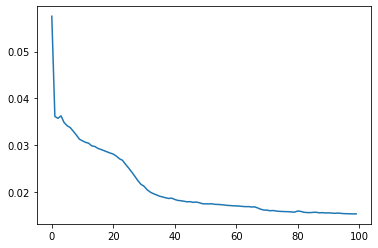

In [ ]:
plt.plot(history)

In [ ]:
# Testing the AE
test_loss = 0

for user in testset.userid.unique():
    itemidx = testset.loc[testset.userid == user, data_description['items']].values
    feedbackidx = testset.loc[testset.userid == user, data_description['feedback']].values
    values = np.ones(len(itemidx), dtype=np.float32)

    user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
    target = user_tensor_test.clone()
    
    output = ae(user_tensor_test)
    target.require_grad = False

    loss = criterion(output, target)
    test_loss += loss.data.item()
    
print('test loss: '+str(test_loss / testset.userid.nunique()))

test loss: 0.02183415055544881


In [ ]:
scores = torch.zeros((len(testset.userid.unique()), data_description['n_items']))
for i, user in enumerate(testset.userid.unique()):
    itemidx = testset.loc[testset.userid == user, data_description['items']].values
    feedbackidx = testset.loc[testset.userid == user, data_description['feedback']].values
    values = np.ones(len(itemidx), dtype=np.float32)

    user_matrix_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().unsqueeze(0).to(device)
    
    output = ae(user_matrix_test)
    scores[i] = output[0][:, -1].T

        
scores = scores.detach().numpy()

In [ ]:
# our
downvote_seen_items(scores, testset, data_description)
make_prediction(scores, holdout, data_description)

HR@5 = 0.0207, MRR@5 = 0.0097, Coverage@5 = 0.2287
HR_pos@5 = 0.0196, HR_neg@5 = 0.0012
MRR_pos@5 = 0.0089, MRR_neg@5 = 0.0007
Matthews@5 = 0.0455
-------------------------------------
HR@10 = 0.0288, MRR@10 = 0.0107, Coverage@10 = 0.2981
HR_pos@10 = 0.0265, HR_neg@10 = 0.0023
MRR_pos@10 = 0.0098, MRR_neg@10 = 0.0009
Matthews@10 = 0.0427
-------------------------------------
HR@20 = 0.0454, MRR@20 = 0.0119, Coverage@20 = 0.4004
HR_pos@20 = 0.0431, HR_neg@20 = 0.0023
MRR_pos@20 = 0.0110, MRR_neg@20 = 0.0009
Matthews@20 = 0.0711
-------------------------------------


(0.010699453252644743, 0.02875215641173088, 0.042746208372664046)